Take random picture from test dataset

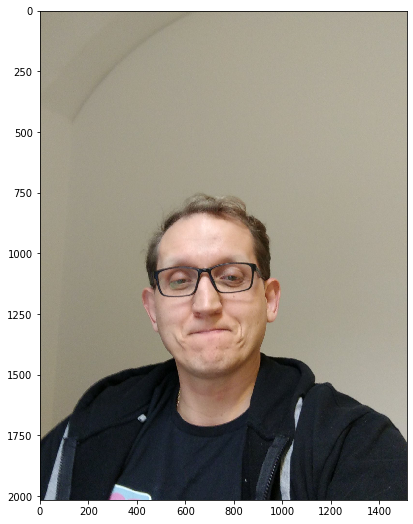

In [19]:
import os, random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter, ExifTags

folder=r"dataset_test"
source_image = Image.open(folder+'/'+random.choice(os.listdir(folder)))

def reorient_image(im):
    try:
        image_exif = im._getexif()
        image_orientation = image_exif[274]
        if image_orientation in (2,'2'):
            return im.transpose(Image.FLIP_LEFT_RIGHT)
        elif image_orientation in (3,'3'):
            return im.transpose(Image.ROTATE_180)
        elif image_orientation in (4,'4'):
            return im.transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (5,'5'):
            return im.transpose(Image.ROTATE_90).transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (6,'6'):
            return im.transpose(Image.ROTATE_270)
        elif image_orientation in (7,'7'):
            return im.transpose(Image.ROTATE_270).transpose(Image.FLIP_TOP_BOTTOM)
        elif image_orientation in (8,'8'):
            return im.transpose(Image.ROTATE_90)
        else:
            return im
    except (KeyError, AttributeError, TypeError, IndexError):
        return im

source_image = reorient_image(source_image)
plt.figure(figsize=(9, 9))
plt.imshow(source_image)

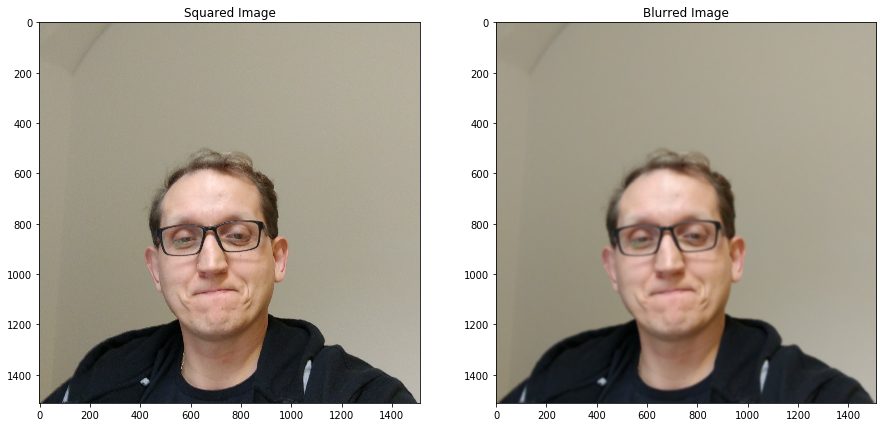

In [20]:
import cv2
import numpy as np

# Display data
def display(display_list, title):
  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
  plt.show()

squared_size = min(source_image.width,source_image.height), min(source_image.width,source_image.height)
squared_image = ImageOps.fit(source_image, squared_size, Image.ANTIALIAS)

first_opencv_image = cv2.cvtColor(np.array(squared_image), cv2.COLOR_RGBA2BGR)
blurred_opencv_image = cv2.GaussianBlur(first_opencv_image,(21,21),0)
# blurred_opencv_image=cv2.bilateralFilter(first_opencv_image, 21,45,45)
blurred_opencv_image = cv2.cvtColor(blurred_opencv_image, cv2.COLOR_BGR2RGB)
blurred_img = Image.fromarray(blurred_opencv_image)

title = ['Squared Image', 'Blurred Image']
display([squared_image,blurred_img],title)

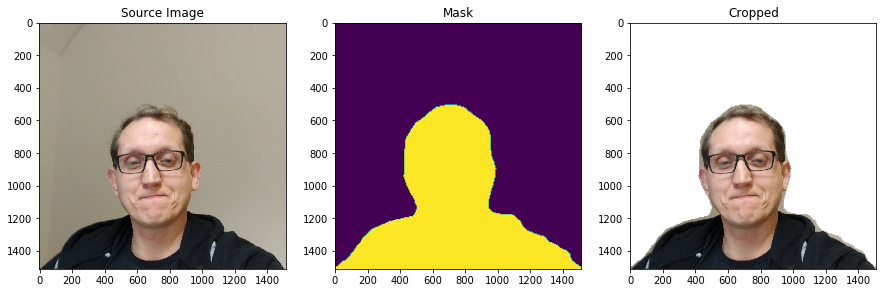

In [21]:
import tensorflow as tf

# Get segmentation Mask
def get_segmentation_mask(input_image):
    # Load TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path="models/deeplabv3_257_mv_gpu.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    # Prepear input data.
    input_shape = input_details[0]['shape']
    input_data = np.array(input_image, dtype=np.float32).reshape(input_shape)
    # Normalised [-1,1]
    input_data = 2.*(input_data - np.min(input_data))/np.ptp(input_data)-1
    interpreter.set_tensor(input_details[0]['index'], input_data)
    # Run model.
    interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    # Get mask image
    return tf.keras.preprocessing.image.array_to_img(create_mask(output_data))

# Argmax for mask
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]


size = 257, 257
thumb = ImageOps.fit(blurred_img, size, Image.ANTIALIAS)

mask_im = get_segmentation_mask(thumb)

resized_mask = mask_im.resize(squared_image.size,Image.BILINEAR)
resized_cropped_im = Image.composite(squared_image.convert("RGBA"), 
                                     Image.new("RGBA", squared_image.size, (255, 255, 255)), 
                                     resized_mask.convert("L"))

title = ['Source Image', 'Mask', 'Cropped']
display([squared_image,resized_mask,resized_cropped_im],title)

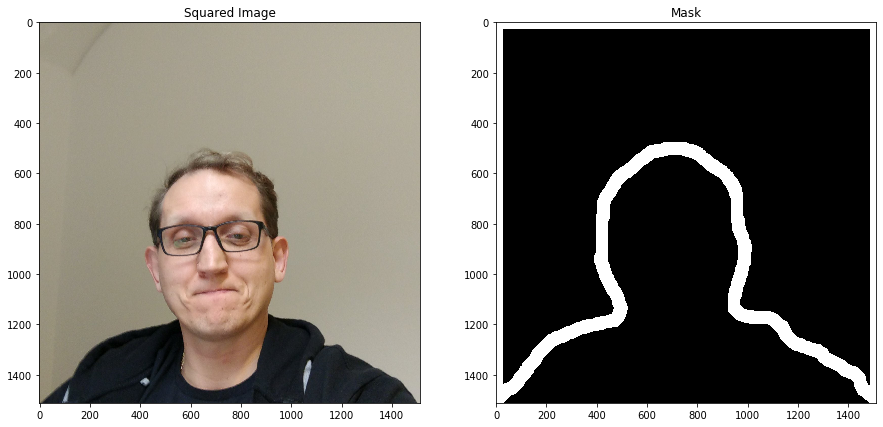

In [22]:

opencv_image = cv2.cvtColor(np.array(resized_cropped_im), cv2.COLOR_RGBA2BGRA)


mask = np.array(Image.new("RGBA", squared_image.size, (0, 0, 0)))

gray = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(gray, 254, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Make contours size depend on resolution
cv2.drawContours(mask, contours, -1, (255,255,255),50)

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 1)
plt.title('Squared Image')
plt.imshow(squared_image)

plt.subplot(1, 2, 2)
plt.title('Mask')
plt.imshow(mask)




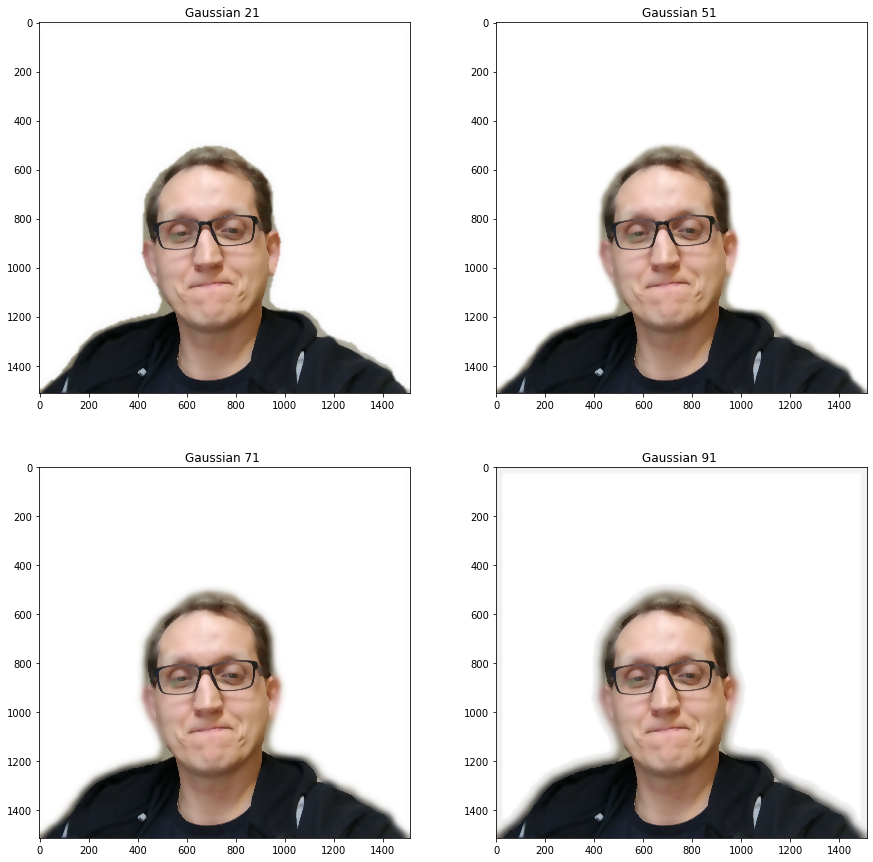

In [23]:
# Display data
def display_with_diffrent_blur(cv_image):
  plt.figure(figsize=(15, 15))
  index = 1
  sigmas = [21, 51, 71, 91]
  for i in sigmas:
    blurred_ga = cv2.GaussianBlur(cv_image,(i,i),0)
    output_ga = np.where(mask==np.array([255, 255, 255,255]), blurred_ga, cv_image)
    output_ga = cv2.cvtColor(output_ga, cv2.COLOR_BGRA2BGR)
    output_ga = cv2.bilateralFilter(output_ga, 21,45,45)
    output_ga = cv2.cvtColor(output_ga, cv2.COLOR_BGR2RGBA)
    plt.subplot(2, 2, index)
    index = index+1
    plt.title("Gaussian {} ".format(i))
    plt.imshow(output_ga)
  plt.show()

display_with_diffrent_blur(opencv_image)
